<a href="https://www.kaggle.com/code/irynabarnych/ai20-lab1?scriptVersionId=173793123" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [20]:
import os
import pandas as pd
import torch


folder = "/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml"

df1 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv")
df2 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv")
df3 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv")
df4 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv")
df5 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv")

df = pd.concat([df1,df2,df3,df4,df5])

df.head()


,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business


In [21]:
df["text"]=df["headlines"]
df=df.drop(columns=["headlines", "description", "content", "url"])
df.head()

,category,text
0,business,Nirmala Sitharaman to equal Morarji Desai’s re...
1,business,"‘Will densify network, want to be at least no...."
2,business,Air India group to induct an aircraft every si...
3,business,Red Sea woes: Exporters seek increased credit ...
4,business,Air India group to induct a plane every 6 days...


In [22]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext


class MyDataset(Dataset):
    def __init__(self, X, y, max_len=100):
        self.X = X
        self.y = y
        self.max_len = max_len
        
        self.label_encoder = LabelEncoder().fit(y)
        #self.vocab = torchtext.vocab.GloVe(name='6B', dim=50)
        self.vocab = torchtext.vocab.Vectors("/kaggle/input/glove6b/glove.6B.50d.txt")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)
        
        text = self.X.iloc[idx]
        tokens = text.split()
        
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            
            tokens += ['<pad>'] * diff
        
        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        
        return X, label[0]
    
    
dataset = MyDataset(df['text'], df['category'])

In [23]:
dataset[0][0].shape

torch.Size([100, 50])

In [24]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [25]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [26]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import math

from torch import Tensor


# Код змінено для batch_first=True

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()
        
        self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim*max_len, num_classes)

    def forward(self, x):
        out = self.pos_encoder(x)
        out = self.encoder(out)
        out = self.flatten(out)
        out = self.linear1(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TextClassifier(encoding_dim=50, max_len=100, num_classes=5).to(device)
model

TextClassifier(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=5000, out_features=5, bias=True)
)

In [30]:
params_num = 0

for param in model.parameters():
    size = param.size()
    
    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

41919

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [32]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.000100), epochs=10, device=cuda

Epoch    1    8sec	loss:       1.37	val_loss:       1.02	accuracy_score:      0.453	val_accuracy_score:      0.675	
Epoch    2    8sec	loss:      0.771	val_loss:      0.535	accuracy_score:      0.757	val_accuracy_score:      0.827	
Epoch    3    8sec	loss:      0.538	val_loss:      0.424	accuracy_score:      0.822	val_accuracy_score:      0.861	
Epoch    4    8sec	loss:      0.457	val_loss:      0.374	accuracy_score:      0.845	val_accuracy_score:      0.874	
Epoch    5    7sec	loss:      0.418	val_loss:       0.35	accuracy_score:      0.859	val_accuracy_score:      0.878	
Epoch    6    8sec	loss:       0.39	val_loss:      0.351	accuracy_score:      0.866	val_accuracy_score:      0.872	
Epoch    7    7sec	loss:      0.374	val_loss:      0.329	accuracy_score:      0.871	val_accuracy_score:      0.884	
Epoch    8    8sec	loss:      0.353	val_loss:      0.318	accuracy_score:      0.879	val_accuracy_score

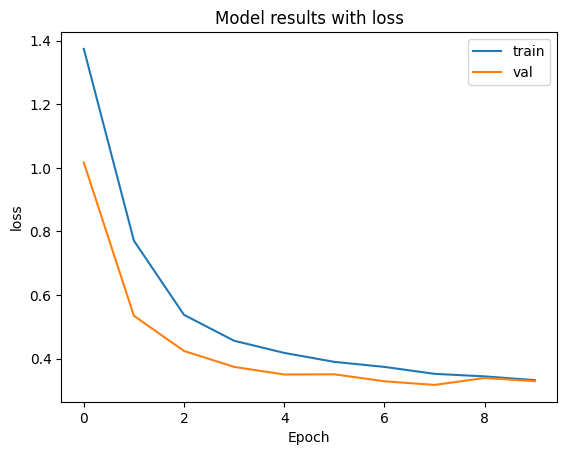

In [34]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

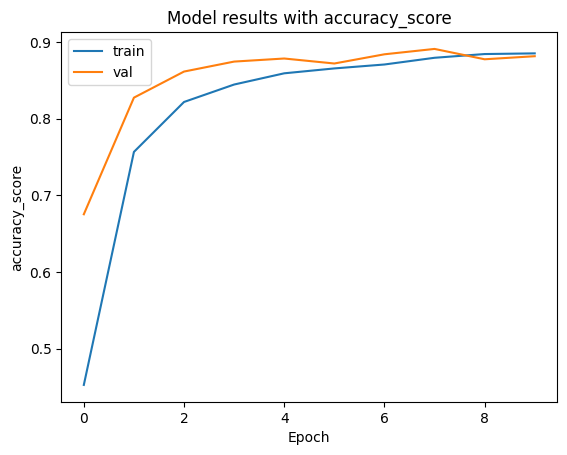

In [35]:
plot_metric(history, 'accuracy_score')

[]

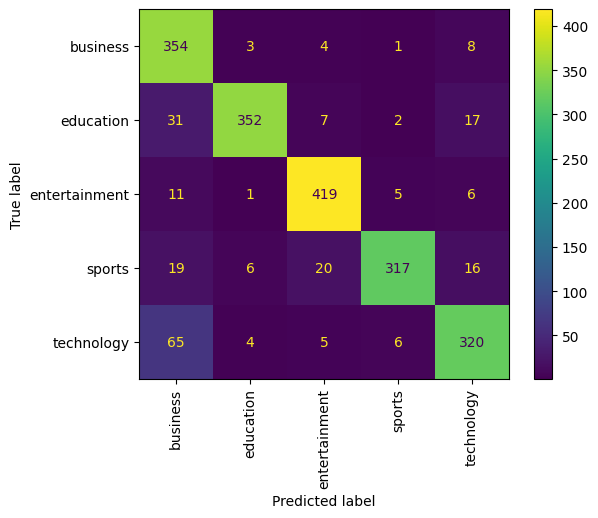

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.label_encoder.classes_))

               precision    recall  f1-score   support

     business       0.74      0.96      0.83       370
    education       0.96      0.86      0.91       409
entertainment       0.92      0.95      0.93       442
       sports       0.96      0.84      0.89       378
   technology       0.87      0.80      0.83       400

     accuracy                           0.88      1999
    macro avg       0.89      0.88      0.88      1999
 weighted avg       0.89      0.88      0.88      1999

